<a href="https://colab.research.google.com/github/SebampitakoDuncan/Chest-X-Ray-Report-Generato/blob/main/EfficientNet_Transformer_model_trained_on_both_local_and_open_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#importing libraries
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
#defining model constants and hyperparameters
IMAGES_PATH = "/content/drive/MyDrive/Frontal Images"
IMAGE_SIZE = (299, 299)
VOCAB_SIZE = 3000
# SEQ_LENGTH = 20
SEQ_LENGTH = 60
EMBED_DIM = 512

# Number of self-attention heads
NUM_HEADS = 2
FF_DIM = 512

BATCH_SIZE = 64
EPOCHS = 70
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
#Generating healthy captions for open source data
import pandas as pd
from pprint import pprint
from IPython.display import clear_output
healthy_captions = pd.read_csv("/content/drive/MyDrive/vivthavn_eda/No disease_findings.csv")
healthy_captions["findings_impression"] = healthy_captions["impression"] + healthy_captions["finding"]
healthy_captions['findings_impression'] = healthy_captions.findings_impression.apply(lambda x: "<start> " + x.strip() + " <end>")
healthy_captions

healthy_text_data = healthy_captions.findings_impression.values.tolist()
# healthy_captions

healthy_captions_mapping = {}
for index,row in healthy_captions.iterrows():
  print(index)
  # print(row.image_id)
  # print(row.findings_impression)
  fni = row.findings_impression
  # fni = "<start> " + fni + " <end>"
  healthy_captions_mapping[row.image_id] = [fni]
  # break

clear_output()
pprint(healthy_captions_mapping)
del healthy_captions

Streaming output truncated to the last 5000 lines.
                                                                   'scoliosis '
                                                                   'of the '
                                                                   'spine. '
                                                                   '<end>'],
 '/content/drive/MyDrive/Frontal Images/CXR71_IM-2273-1001.png': ['<start> no '
                                                                  'acute '
                                                                  'cardiopulmonary '
                                                                  'disease.the '
                                                                  'heart is '
                                                                  'upper '
                                                                  'limits of '
                                                                  'normal in '
      

In [5]:
#Generating healthy captions for local data
import pandas as pd
from pprint import pprint
from IPython.display import clear_output
healthy_local_captions = pd.read_csv("/content/drive/MyDrive/Local_dataset_dataframes/No_disease_local_data - Sheet1 (1).csv")
healthy_local_captions["findings_impression"] = healthy_local_captions["impression"] + healthy_local_captions["finding"]
healthy_local_captions['findings_impression'] = healthy_local_captions.findings_impression.apply(lambda x: "<start> " + x.strip() + " <end>")
healthy_local_captions

healthy_local_text_data = healthy_local_captions.findings_impression.values.tolist()
# healthy_local_captions

healthy_local_captions_mapping = {}
for index,row in healthy_local_captions.iterrows():
  print(index)
  # print(row.image_id)
  # print(row.findings_impression)
  fni = row.findings_impression
  # fni = "<start> " + fni + " <end>"
  healthy_local_captions_mapping[row.image_id] = [fni]
  # break

clear_output()
pprint(healthy_local_captions_mapping)
del healthy_local_captions

{'/content/drive/MyDrive/Healthy/002_cleanup.jpg': ['<start> Normal Chest '
                                                    'X-rayNormal Chest X-ray '
                                                    '<end>'],
 '/content/drive/MyDrive/Healthy/003_cleanup.jpg': ['<start> Normal Chest '
                                                    'X-rayNormal Chest X-ray '
                                                    '<end>'],
 '/content/drive/MyDrive/Healthy/004_cleanup.jpg': ['<start> Normal Chest '
                                                    'X-rayNormal Chest X-ray '
                                                    '<end>'],
 '/content/drive/MyDrive/Healthy/005_cleanup.jpg': ['<start> Normal Chest '
                                                    'X-rayNormal Chest X-ray '
                                                    '<end>'],
 '/content/drive/MyDrive/Healthy/006_cleanup.jpg': ['<start> Normal Chest '
                                                    'X-r

In [6]:
#Generating unhealthy open source captions
import pandas as pd
from pprint import pprint
from IPython.display import clear_output
unhealthy_captions = pd.read_csv("/content/drive/MyDrive/vivthavn_eda/Unhealthy_findings_new.csv")
unhealthy_captions["findings_impression"] = unhealthy_captions["impression"] + unhealthy_captions["finding"]
unhealthy_captions['findings_impression'] = unhealthy_captions.findings_impression.apply(lambda x: "<start> " + x.strip() + " <end>")

unhealthy_text_data = unhealthy_captions.findings_impression.values.tolist()
# unhealthy_captions

unhealthy_captions_mapping = {}
for index,row in unhealthy_captions.iterrows():
  print(index)
  # print(row.image_id)
  # print(row.findings_impression)
  fni = row.findings_impression
  # fni = "<start> " + fni + " <end>"
  unhealthy_captions_mapping[row.image_id] = [fni]
  # break

clear_output()
pprint(unhealthy_captions_mapping)
del unhealthy_captions

Streaming output truncated to the last 5000 lines.
                                                                  'thoracic '
                                                                  'spine. '
                                                                  '<end>'],
 '/content/drive/MyDrive/Frontal Images/CXR411_IM-2056-1001.png': ['<start> '
                                                                   'minimal '
                                                                   'left '
                                                                   'basilar '
                                                                   'opacity '
                                                                   'most  '
                                                                   'representing '
                                                                   'atelectasis '
                                                                   'or chronic '
          

In [7]:
#Generating unhealthy local captions
import pandas as pd
from pprint import pprint
from IPython.display import clear_output
unhealthy_local_captions = pd.read_csv("/content/drive/MyDrive/Local_dataset_dataframes/Disease_local_data - Sheet1.csv")
unhealthy_local_captions["findings_impression"] = unhealthy_local_captions["impression"] + unhealthy_local_captions["finding"]
unhealthy_local_captions['findings_impression'] = unhealthy_local_captions.findings_impression.apply(lambda x: "<start> " + x.strip() + " <end>")

unhealthy_local_text_data = unhealthy_local_captions.findings_impression.values.tolist()
# unhealthy_local_captions

unhealthy_local_captions_mapping = {}
for index,row in unhealthy_local_captions.iterrows():
  print(index)
  # print(row.image_id)
  # print(row.findings_impression)
  fni = row.findings_impression
  # fni = "<start> " + fni + " <end>"
  unhealthy_local_captions_mapping[row.image_id] = [fni]
  # break

clear_output()
pprint(unhealthy_local_captions_mapping)
del unhealthy_local_captions

{'/content/drive/MyDrive/TB/027_cleanup.jpg': ['<start> Consolidation. Active '
                                               'TBLung opacity in the right '
                                               'lung lower zone.  '
                                               'Consolidation in the right '
                                               'lung lower zone. <end>'],
 '/content/drive/MyDrive/TB/033_cleanup.jpg': ['<start> Consolidation. Active '
                                               'TBLung opacity in the right '
                                               'lung mid and lower zone. '
                                               'Consolidation in the right '
                                               'lung mid and lower zone. '
                                               '<end>'],
 '/content/drive/MyDrive/TB/035_cleanup.jpg': ['<start> Consolidation.  Active '
                                               'TBLung opacity in the right '
                      

In [8]:
def train_val_split(caption_data, train_size=0.7, shuffle=True):

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)
    

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the open source dataset


train_data = {}
valid_data = {}
test_data = {}

text_data = []
for mappings,txt_data in zip([healthy_captions_mapping, unhealthy_captions_mapping], [healthy_text_data, unhealthy_text_data]):
    text_data.extend(txt_data)

    t_data, v_data = train_val_split(mappings, train_size=0.7)
    tst_data, val_data = train_val_split(v_data, train_size=0.5)

    train_data.update(t_data)
    valid_data.update(val_data)
    test_data.update(tst_data)

print("Number of  training samples: ", len(train_data))
print("Number of   validation samples: ", len(valid_data))
print("Number of   test samples: ", len(test_data))

Number of  training samples:  2054
Number of   validation samples:  441
Number of   test samples:  440


In [9]:
train_local_data = {}
valid_local_data = {}
test_local_data = {}

text_local_data = []
for mappings,local_txt_data in zip([healthy_local_captions_mapping, unhealthy_local_captions_mapping], [healthy_local_text_data, unhealthy_local_text_data]):
    text_data.extend(local_txt_data)

    t_data, v_data = train_val_split(mappings, train_size=0.7)
    tst_data, val_data = train_val_split(v_data, train_size=0.5)

    train_local_data.update(t_data)
    valid_local_data.update(val_data)
    test_local_data.update(tst_data)
print("Number of local training samples: ", len(train_local_data))
print("Number of  local validation samples: ", len(valid_local_data))
print("Number of  local test samples: ", len(test_local_data))

Number of local training samples:  196
Number of  local validation samples:  44
Number of  local test samples:  42


In [10]:
txt_data

['<start> .   mm left lung nodular opacity. recommend comparison with prior images. if prior images are not available than further evaluation with ct chest is recommended. old chest film from     from  was reviewed and the questionable nodule was not  seen.heart size  aortic and mediastinal contours are within normal limits. the lungs are clear. no visible pneumothorax or large pleural effusion.   mm nodular opacity overlies the left anterior  th rib on the frontal view. no focal bony abnormality identified. <end>',
 '<start> .   mm left midlung nodule.  since . comparison to interval outside film would be helpful to assess the chronicity of this nodule. if old films are not available  or if this is   chest ct scan could be  to better define this.heart size and pulmonary vascularity appear within normal limits. the lungs are free of focal airspace disease. no pleural effusion or pneumothorax is seen. in the left midlung zone  there has been development of a small lung nodule. this meas

In [11]:
local_txt_data

['<start> Consolidation. Active TBLung opacity in the right lung lower zone.  Consolidation in the right lung lower zone. <end>',
 '<start> Consolidation. Active TBLung opacity in the right lung mid and lower zone. Consolidation in the right lung mid and lower zone. <end>',
 '<start> Consolidation.  Active TBLung opacity in the right lung mid and lower zone. Consolidation in the right lung mid and lower zone. <end>',
 '<start> Interstitial pneumonitisLung shadows in the left and right lung mid and lower zone. <end>',
 '<start> Consolidation. Cavitation.There is a lung opacity and consilidation in the upper zone. <end>',
 '<start> Consolidation. Cavitation.There is a lung opacity and consolidation  in the upper zone. <end>',
 '<start> Consolidation.  Active TBLung opacity located in the right lung upper and mid zone. Consolidation in the right lung upper and mid zone. <end>',
 '<start> Consolidation and Fibrosis.  Active TBConsolidation and Fibrosis.  Active TB <end>',
 '<start> Consoli

In [12]:
text_data

['<start> normal chest x .the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no  of a pleural effusion. there is no evidence of pneumothorax. <end>',
 '<start> no acute cardiopulmonary process.the cardiomediastinal silhouette is within normal limits for size and contour. the lungs are normally inflated without evidence of focal airspace disease  pleural effusion  or pneumothorax. stable calcified granuloma within the right upper lung. no acute bone abnormality.. <end>',
 '<start> no active disease.both lungs are clear and expanded. heart and mediastinum normal. <end>',
 '<start> no acute findings.cardiac and mediastinal contours are within normal limits. the lungs are clear. bony structures are intact. <end>',
 '<start> no acute cardiopulmonary disease.the lungs appear clear. there are no focal airspace opacities to suggest pneumonia. the pleural spaces are clear. the heart and pulmonary  are nor

In [13]:
train_data

{'/content/drive/MyDrive/Frontal Images/CXR3103_IM-1454-1001.png': ['<start> no acute cardiopulmonary abnormality..cardiomediastinal silhouette stable and unremarkable. stable eventration of the right hemidiaphragm. there is redemonstration without significant interval change of mild subsegmental atelectasis of the left base. pneumonia seen on ct examination dated     not seen on prior chest x   is not seen either on  chest x . <end>'],
 '/content/drive/MyDrive/Frontal Images/CXR1277_IM-0185-1001.png': ['<start> no acute cardiopulmonary disease.pa and lateral views the chest were obtained. the cardiomediastinal silhouette is normal in size and configuration. the lungs are well aerated. no pneumothorax  pleural effusion  or lobar air space consolidation.  right middle lobe collapse appears less distinct than on prior study. <end>'],
 '/content/drive/MyDrive/Frontal Images/CXR395_IM-2019-1001.png': ['<start> no evidence of acute cardiopulmonary process.the cardiac and mediastinal silhoue

In [14]:
train_local_data

{'/content/drive/MyDrive/Healthy/025_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/286_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/241_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/057_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/269_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/137_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/119_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/006_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/236_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/161_

In [15]:
#function to merge local and open train dictionary 
def Merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [16]:
combined_train_data = Merge(train_data, train_local_data)
print(combined_train_data)

{'/content/drive/MyDrive/Frontal Images/CXR3103_IM-1454-1001.png': ['<start> no acute cardiopulmonary abnormality..cardiomediastinal silhouette stable and unremarkable. stable eventration of the right hemidiaphragm. there is redemonstration without significant interval change of mild subsegmental atelectasis of the left base. pneumonia seen on ct examination dated     not seen on prior chest x   is not seen either on  chest x . <end>'], '/content/drive/MyDrive/Frontal Images/CXR1277_IM-0185-1001.png': ['<start> no acute cardiopulmonary disease.pa and lateral views the chest were obtained. the cardiomediastinal silhouette is normal in size and configuration. the lungs are well aerated. no pneumothorax  pleural effusion  or lobar air space consolidation.  right middle lobe collapse appears less distinct than on prior study. <end>'], '/content/drive/MyDrive/Frontal Images/CXR395_IM-2019-1001.png': ['<start> no evidence of acute cardiopulmonary process.the cardiac and mediastinal silhouett

In [17]:
len(combined_train_data)

2250

In [18]:
test_data

{'/content/drive/MyDrive/Frontal Images/CXR553_IM-2155-2001.png': ['<start> no acute cardiopulmonary process. .normal heart size and mediastinal contours. scattered calcified granulomas. hyperexpanded lungs. no focal airspace disease. no pneumothorax or pleural effusion. degenerative changes in the spine without acute bony abnormalities. <end>'],
 '/content/drive/MyDrive/Frontal Images/CXR527_IM-2137-1001.png': ['<start> no acute radiographic cardiopulmonary process. .cardiac and mediastinal  appear normal. no visible pneumothorax  focal airspace opacity  or pleural effusion is seen. no visible free air under the diaphragm. the osseous structures appear intact. <end>'],
 '/content/drive/MyDrive/Frontal Images/CXR406_IM-2054-1001.png': ['<start> no acute cardiopulmonary abnormality.heart size normal. no pneumothorax  large pleural effusion  or focal airspace disease. bony structures appear intact. calcified right hilar nodules consistent with chronic granulomatous disease. <end>'],
 '/c

In [19]:
test_local_data

{'/content/drive/MyDrive/Healthy/020_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/071_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/178_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/302_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/136_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/213_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/011_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/301_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/016_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/138_

In [20]:
valid_data

{'/content/drive/MyDrive/Frontal Images/CXR3359_IM-1612-4001.png': ['<start> no acute cardiopulmonary findings.heart size normal. no focal airspace disease. no pneumothorax or effusions. <end>'],
 '/content/drive/MyDrive/Frontal Images/CXR756_IM-2307-1001.png': ['<start> no acute cardiopulmonary disease.normal cardiomediastinal silhouette. no airspace consolidation  pneumothorax  pleural effusion  or pulmonary edema. no acute bony abnormality. <end>'],
 '/content/drive/MyDrive/Frontal Images/CXR283_IM-1248-1001.png': ['<start> normal chest film.the lungs are clear. the cardiomediastinal silhouette is within normal limits. no pleural effusion is identified. <end>'],
 '/content/drive/MyDrive/Frontal Images/CXR94_IM-2436-1001.png': ['<start> no acute cardiopulmonary abnormalities.heart size  mediastinal contour  and pulmonary vascularity are similar to comparison exam and within normal limits. no focal consolidation  suspicious pulmonary opacity  pleural effusion  or pneumothorax. the vis

In [21]:
valid_local_data

{'/content/drive/MyDrive/Healthy/058_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/096_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/227_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/260_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/055_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/029_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/162_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/230_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/066_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/151_

In [22]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

In [23]:
def read_image(img_path, size=IMAGE_SIZE):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def make_dataset(images, captions):
    img_dataset = tf.data.Dataset.from_tensor_slices(images).map(
        read_image, num_parallel_calls=AUTOTUNE
    )
    cap_dataset = tf.data.Dataset.from_tensor_slices(captions).map(
        vectorization, num_parallel_calls=AUTOTUNE
    )
    dataset = tf.data.Dataset.zip((img_dataset, cap_dataset))
    dataset = dataset.batch(BATCH_SIZE).shuffle(256).prefetch(AUTOTUNE)
    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(combined_train_data.keys()), list(combined_train_data.values()))
valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))
test_dataset = make_dataset(list(test_data.keys()), list(test_data.values()))

In [24]:
import random
shuffled = list(train_local_data.values())
random.shuffle(shuffled)
train_local_data_shuffled=dict(zip(train_local_data, shuffled))

In [25]:
train_local_data_shuffled

{'/content/drive/MyDrive/Healthy/025_cleanup.jpg': ['<start> Consolidation. Cavitation.Active TB.Compensatory hyperinflation of right lung.Abnormal hyperluceny in upper and mid lower zone.Lung opacity and consolidation in upper and mid lower zone. <end>'],
 '/content/drive/MyDrive/Healthy/286_cleanup.jpg': ['<start> Pleural effusion. Active TBModerate left lung pleural effusion. Blunted left costophrenic angle. <end>'],
 '/content/drive/MyDrive/Healthy/241_cleanup.jpg': ['<start> Consolidation.  Active TBLung opacity in the right lung mid and lower zone. Consolidation in the right lung mid and lower zone. <end>'],
 '/content/drive/MyDrive/Healthy/057_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/269_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/137_cleanup.jpg': ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 '/content/drive/MyDrive/Healthy/119_cleanup.jpg': ['<sta

In [26]:
#train_local_dataset

In [27]:
list(train_data.values())

[['<start> no acute cardiopulmonary abnormality..cardiomediastinal silhouette stable and unremarkable. stable eventration of the right hemidiaphragm. there is redemonstration without significant interval change of mild subsegmental atelectasis of the left base. pneumonia seen on ct examination dated     not seen on prior chest x   is not seen either on  chest x . <end>'],
 ['<start> no acute cardiopulmonary disease.pa and lateral views the chest were obtained. the cardiomediastinal silhouette is normal in size and configuration. the lungs are well aerated. no pneumothorax  pleural effusion  or lobar air space consolidation.  right middle lobe collapse appears less distinct than on prior study. <end>'],
 ['<start> no evidence of acute cardiopulmonary process.the cardiac and mediastinal silhouettes are unremarkable. the lungs are well expanded and clear. there are no focal air space opacities. there is no pneumothorax or effusion. there are calcified hilar lymph  suggesting prior granulo

In [28]:
list(train_local_data_shuffled.values())

[['<start> Consolidation. Cavitation.Active TB.Compensatory hyperinflation of right lung.Abnormal hyperluceny in upper and mid lower zone.Lung opacity and consolidation in upper and mid lower zone. <end>'],
 ['<start> Pleural effusion. Active TBModerate left lung pleural effusion. Blunted left costophrenic angle. <end>'],
 ['<start> Consolidation.  Active TBLung opacity in the right lung mid and lower zone. Consolidation in the right lung mid and lower zone. <end>'],
 ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 ['<start> Pleural effusion. Active TBThe costrophrenic angles are abnormal and  blunted. <end>'],
 ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 ['<start> Normal Chest X-rayNormal Chest X-ray <end>'],
 ['<start> Pleural effusion. Active TBSmall right lung pleural effusion. Blunted right costophrenic angle. <end>'],
 ['<start> Normal Chest X-ra

In [29]:
import random
shuffled = list(valid_local_data.values())
random.shuffle(shuffled)
valid_local_data_shuffled=dict(zip(valid_local_data, shuffled))

In [30]:
# Pass the list of images and the list of corresponding captions
valid_local_dataset = make_dataset(list(valid_local_data_shuffled.keys()), list(valid_local_data_shuffled.values()))
test_local_dataset = make_dataset(list(test_local_data.keys()), list(test_local_data.values()))

In [31]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 60), dtype=tf.int64, name=None))>

In [32]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, 1280))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = layers.Dense(embed_dim, activation="relu")
        self.layernorm_1 = layers.LayerNormalization()

    def call(self, inputs, training, mask=None):
        inputs = self.dense_proj(inputs)
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=None
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        return proj_input


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        
        self.dense_proj = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
      

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE)
        self.dropout_1 = layers.Dropout(0.1)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)
        inputs = self.dropout_1(inputs, training=training)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=combined_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)


        proj_output = self.dense_proj(out_2)
        proj_out = self.layernorm_3(out_2 + proj_output)
        proj_out = self.dropout_2(proj_out, training=training)

        preds = self.out(proj_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=1,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_loss_and_acc(self, batch_data, training=True):
        batch_img, batch_seq = batch_data
        # print("batch_img: ", batch_img.shape)
        # print("batch_seq: ", batch_seq.shape)
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

  
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                # 3. Pass image embeddings to encoder
                encoder_out = self.encoder(img_embed, training=training)

                batch_seq_inp = batch_seq[:, i, :-1]
                batch_seq_true = batch_seq[:, i, 1:]
                # print("batch_seq_inp: ", batch_seq_inp.shape)
                # print("batch_seq_true: ", batch_seq_true.shape)

                # 4. Compute the mask for the input sequence
                mask = tf.math.not_equal(batch_seq_inp, 0)

                # 5. Pass the encoder outputs, sequence inputs along with
                # mask to the decoder
                batch_seq_pred = self.decoder(
                    batch_seq_inp, encoder_out, training=training, mask=mask
                )

                # 6. Calculate loss and accuracy
                loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
                acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)

                # 7. Update the batch loss and batch accuracy
                batch_loss += loss
                batch_acc += acc

            # 8. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 9. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 10. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        return batch_loss, batch_acc / float(self.num_captions_per_image)

    def train_step(self, batch_data):
        loss, acc = self._compute_loss_and_acc(batch_data)
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        loss, acc = self._compute_loss_and_acc(batch_data, training=False)
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(
    embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=NUM_HEADS
)
decoder = TransformerDecoderBlock(
    embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=NUM_HEADS
)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder
)

16705208/16705208 [==============================] - 2s 0us/step


In [33]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(), loss=cross_entropy)

# Fit the model
history = caption_model.fit(
    train_dataset, 
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/70
36/36 [==============================] - 1031s 5s/step - loss: 4.5827 - acc: 0.1469 - val_loss: 3.1044 - val_acc: 0.4056
Epoch 2/70
36/36 [==============================] - 25s 406ms/step - loss: 2.7858 - acc: 0.4307 - val_loss: 2.4480 - val_acc: 0.4814
Epoch 3/70
36/36 [==============================] - 26s 408ms/step - loss: 2.3574 - acc: 0.5034 - val_loss: 2.0920 - val_acc: 0.5341
Epoch 4/70
36/36 [==============================] - 24s 407ms/step - loss: 2.0854 - acc: 0.5093 - val_loss: 1.9392 - val_acc: 0.5534
Epoch 5/70
36/36 [==============================] - 25s 411ms/step - loss: 1.9395 - acc: 0.5659 - val_loss: 1.7357 - val_acc: 0.5911
Epoch 6/70
36/36 [==============================] - 25s 411ms/step - loss: 1.7649 - acc: 0.6155 - val_loss: 1.5451 - val_acc: 0.6234
Epoch 7/70
36/36 [==============================] - 26s 413ms/step - loss: 1.6176 - acc: 0.6100 - val_loss: 1.4741 - val_acc: 0.6374
Epoch 8/70
36/36 [==============================] - 25s 404ms/step - l

In [34]:
caption_model.evaluate(test_local_dataset)

1/1 [==============================] - 20s 20s/step - loss: 1.7747 - acc: 0.7112


[1.7747067213058472, 0.7111517190933228]

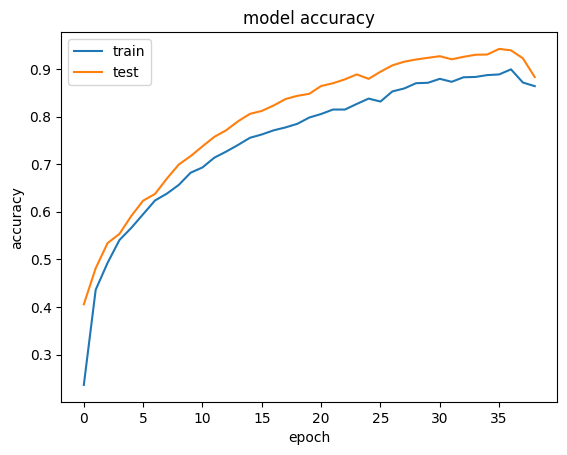

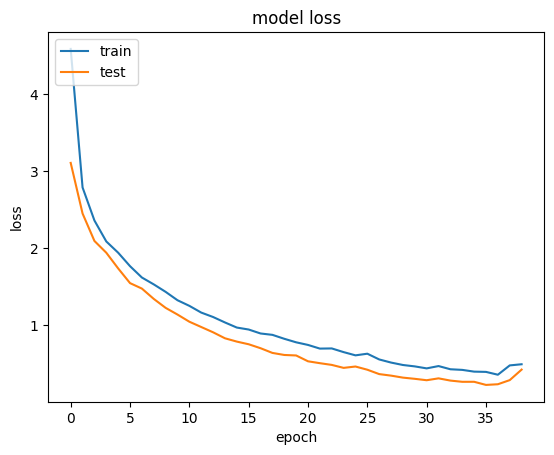

In [36]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
# BLEU Scores for local data
import numpy as np
import tensorflow as tf
import nltk
nltk.download('punkt')
import nltk.translate.bleu_score as bleu
from nltk.tokenize import word_tokenize

vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(test_local_data.keys())

def bleu_score_calculator():
    references = []
    translations = []
    for sample_img_path in valid_images:
        # Read the image from the disk
        sample_img = read_image(sample_img_path)
        img = sample_img.numpy().astype(np.uint8)

        # Pass the image to the CNN
        img = tf.expand_dims(sample_img, 0)
        img = caption_model.cnn_model(img)

        # Pass the image features to the Transformer encoder
        encoded_img = caption_model.encoder(img, training=False)

        # Generate the caption using the Transformer decoder
        decoded_caption = "<start> "
        for j in range(max_decoded_sentence_length):
            tokenized_caption = vectorization([decoded_caption])[:, :-1]
            mask = tf.math.not_equal(tokenized_caption, 0)
            predictions = caption_model.decoder(
                tokenized_caption, encoded_img, training=False, mask=mask
            )
            sampled_token_index = np.argmax(predictions[0, j, :])
            sampled_token = index_lookup[sampled_token_index]
            if sampled_token == "<end>":
                break
            decoded_caption += " " + sampled_token

        # Remove the start and end tokens and add the predicted and actual captions to the list of translations and references
        actual = test_local_data[sample_img_path][0].replace("<start> ", "").replace(" <end>", "").strip().lower()
        actual = ''.join(c for c in actual if c.isalnum() or c.isspace())
        actual = word_tokenize(actual)
        references.append([actual])
        predicted = decoded_caption.replace("<start> ", "").replace(" <end>", "").strip().lower()
        predicted = ''.join(c for c in predicted if c.isalnum() or c.isspace())
        predicted = word_tokenize(predicted)
        translations.append(predicted)

    # Calculate the BLEU score for all the translations with respect to the references
    weights = [(1.0, 0.0, 0.0, 0.0), (0.5, 0.5, 0.0, 0.0), (0.3, 0.3, 0.3, 0.0), (0.25, 0.25, 0.25, 0.25)]
    smoothing_fn = bleu.SmoothingFunction()
    bleu_scores = [bleu.corpus_bleu(references, translations, weights=w, smoothing_function=smoothing_fn.method1) for w in weights]
    print("BLEU Scores: ", bleu_scores)

bleu_score_calculator()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


BLEU Scores:  [0.1990671070919595, 0.19477119484768354, 0.20354674947897805, 0.1844166938917726]


In [38]:
#BLEU Scores for  open source test data
import numpy as np
import tensorflow as tf
import nltk.translate.bleu_score as bleu
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')

vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(test_data.keys())

def bleu_score_calculator():
    references = []
    translations = []
    for sample_img_path in valid_images:
        try:
            # Read the image from the disk
            sample_img = read_image(sample_img_path)
            img = sample_img.numpy().astype(np.uint8)

            # Pass the image to the CNN
            img = tf.expand_dims(sample_img, 0)
            img = caption_model.cnn_model(img)

            # Pass the image features to the Transformer encoder
            encoded_img = caption_model.encoder(img, training=False)

            # Generate the caption using the Transformer decoder
            decoded_caption = "<start> "
            for j in range(max_decoded_sentence_length):
                tokenized_caption = vectorization([decoded_caption])[:, :-1]
                mask = tf.math.not_equal(tokenized_caption, 0)
                predictions = caption_model.decoder(
                    tokenized_caption, encoded_img, training=False, mask=mask
                )
                sampled_token_index = np.argmax(predictions[0, j, :])
                sampled_token = index_lookup[sampled_token_index]
                if sampled_token == "<end>":
                    break
                decoded_caption += " " + sampled_token

            # Remove the start and end tokens and add the predicted and actual captions to the list of translations and references
            actual = test_data[sample_img_path][0].replace("<start> ", "").replace(" <end>", "").strip().lower()
            actual = ''.join(c for c in actual if c.isalnum() or c.isspace())
            actual = word_tokenize(actual)
            references.append([actual])
            predicted = decoded_caption.replace("<start> ", "").replace(" <end>", "").strip().lower()
            predicted = ''.join(c for c in predicted if c.isalnum() or c.isspace())
            predicted = word_tokenize(predicted)
            translations.append(predicted)
        except:
            continue

    # Calculate the BLEU score for all the translations with respect to the references
    weights = [(1.0, 0.0, 0.0, 0.0), (0.5, 0.5, 0.0, 0.0), (0.3, 0.3, 0.3, 0.0), (0.25, 0.25, 0.25, 0.25)]
    smoothing_fn = bleu.SmoothingFunction()
    bleu_scores = [bleu.corpus_bleu(references, translations, weights=w, smoothing_function=smoothing_fn.method1) for w in weights]
    print("BLEU Scores: ", bleu_scores)

bleu_score_calculator()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


BLEU Scores:  [0.32610437480216403, 0.19957709817466224, 0.15757436316144002, 0.08924406154989202]


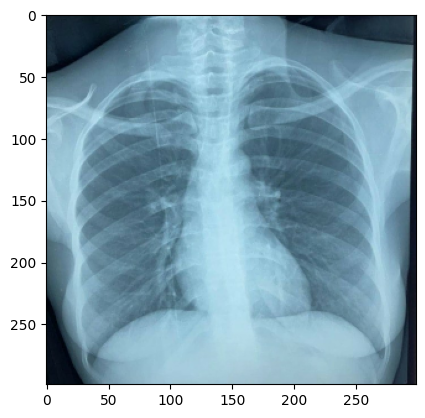

ACTUAL:  Normal Chest X-rayNormal Chest X-ray
PREDICTED CAPTION: normal chest xraynormal chest xray


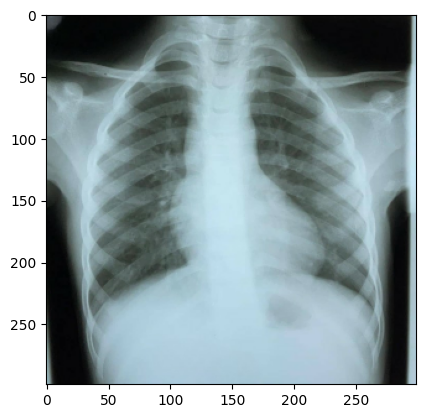

ACTUAL:  Normal Chest X-rayNormal Chest X-ray
PREDICTED CAPTION: normal chest xraynormal chest xray


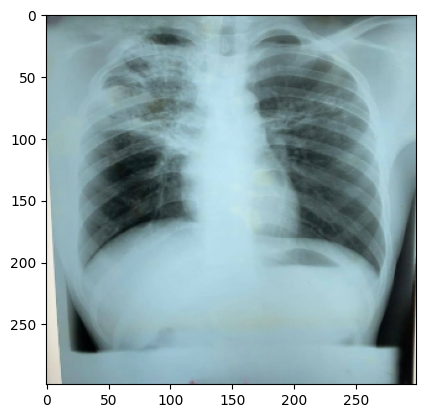

ACTUAL:  Consolidation. Cavitation.  Active TBRight lung opacity. Consolidation in the right lung upper and mid zone. Single thick cavity in the right lung mid zone. Left lung opacity in the mid zone. Consolidation in the left lung mid zone.
PREDICTED CAPTION: normal chest xraynormal chest xray


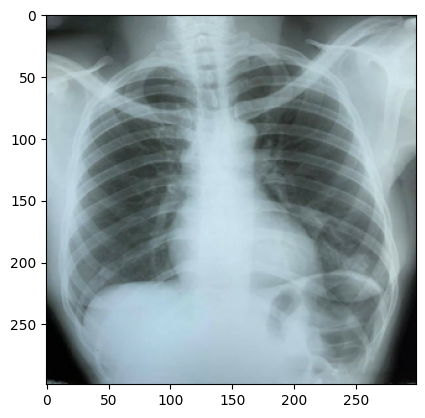

ACTUAL:  Normal Chest X-rayNormal Chest X-ray
PREDICTED CAPTION: active tb bronchopneumoniathere are other lung shadows and reticulonodular masses in upper and mid lower zone


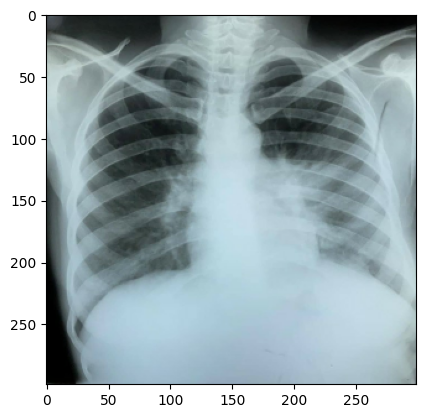

ACTUAL:  Consolidation. Active TBLung opacity and consolidation in mid and lower zone.
PREDICTED CAPTION: normal chest xraynormal chest xray


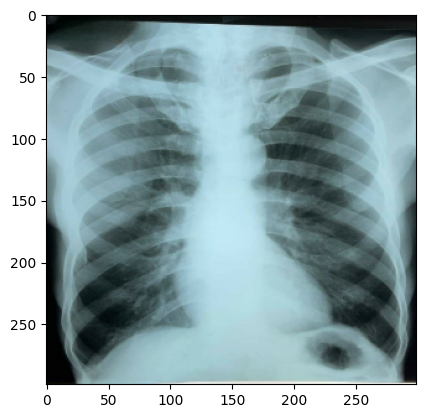

ACTUAL:  Normal Chest X-rayNormal Chest X-ray
PREDICTED CAPTION: normal chest xraynormal chest xray


In [45]:
#Visualing test local data inference
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(test_local_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img_path = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = read_image(sample_img_path)
    img = sample_img.numpy().astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    print("ACTUAL: ", test_local_data[sample_img_path][0].replace("<start> ", "").replace("<end>", "").strip())
    print("PREDICTED CAPTION:", end=" ")
    print(decoded_caption.replace("<start> ", "").replace("<end>", "").strip())
    
    


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()

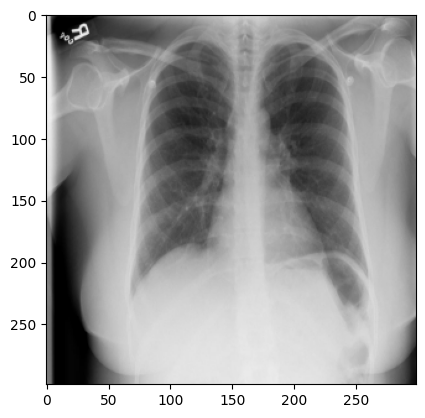

ACTUAL:  no acute findingsheart size within normal limits  stable mediastinal and hilar contours. no focal alveolar consolidation  no definite pleural effusion seen. bronchovascular crowding without typical findings of pulmonary edema.
PREDICTED CAPTION: no acute cardiopulmonary abnormality left midlung subsegmental atelectasis or scarcardiomediastinal silhouette is within normal limits of size and appearance pulmonary vascularity is unremarkable there are opacities in the left base subsegmental atelectasis or scarring or subsegmental atelectasis no focal airspace disease or pleural effusion thoracic spine osteophytes there are noted


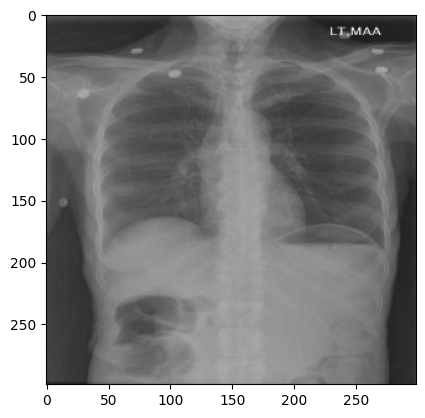

ACTUAL:  normal chestheart size normal. lungs are clear.  are normal. no pneumonia  effusions  edema  pneumothorax  adenopathy  nodules or masses.
PREDICTED CAPTION: no acute cardiopulmonary abnormalitythe lungs are clear bilaterally specifically no evidence of focal consolidation pneumothorax or pleural effusion cardio mediastinal silhouette is unremarkable visualized osseous structures of the thorax are without acute abnormality


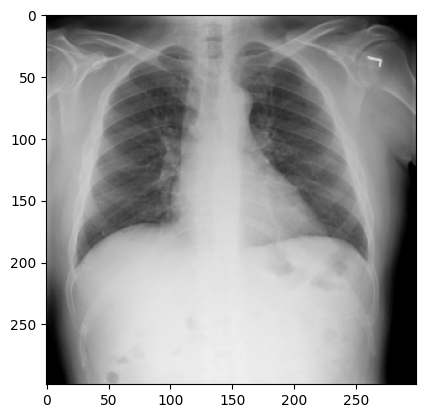

ACTUAL:  no acute findingsheart size within normal limits  stable mediastinal and hilar contours  mediastinal calcifications suggest a previous granulomatous process. no focal alveolar consolidation  no definite pleural effusion seen. no typical findings of pulmonary edema.
PREDICTED CAPTION: no acute cardiopulmonary findingsthe heart size and mediastinal contours appear within normal limits no focal airspace consolidation pleural effusion or pneumothorax no acute bony abnormalities


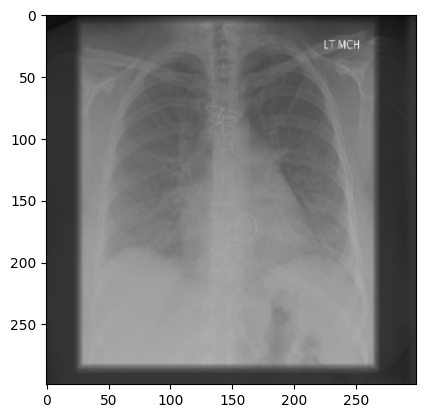

ACTUAL:  . mildly prominent interstitial markings  which could represent interstitial edema.  . mild blunting of the posterior sulcus  which could represent a small effusion.sternotomy  appear intact. surgical clips overlying the mediastinum. mitral valve replacement seen. low lung volumes. the interstitial markings appear prominent  which may represent interstitial edema. there is mild blunting of the posterior sulcus on the lateral view  which could represent a small effusion. no pneumothorax. no acute bony abnormality.
PREDICTED CAPTION: small bilateral pleural effusionsthe lungs are clear the cardiomediastinal silhouette is within normal limits small pleural effusion is identified


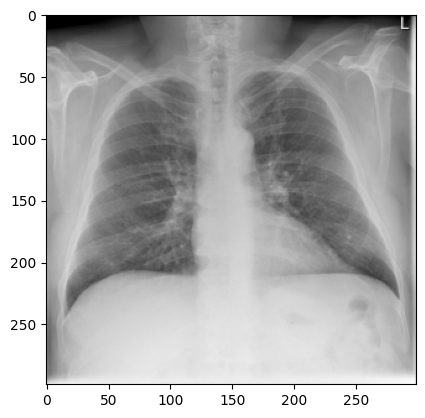

ACTUAL:  . no evidence of active disease.the heart size and pulmonary vascularity appear within normal limits. the lungs are free of focal airspace disease. no pleural effusion or pneumothorax is seen. calcified granuloma are present. degenerative changes are present in the spine.
PREDICTED CAPTION: no acute cardiopulmonary abnormality left upper lobe pulmonary nodule recommend comparison to document stability if available recommend further characterization with a nodule in the right upper lobe infiltratestable nonenlarged cardiomediastinal silhouette left upper lobe nodule not well demonstrated on today s study and may be artifact no acute bony abnormalities


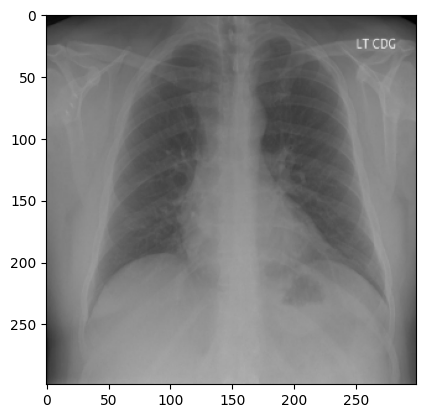

ACTUAL:  normal chestheart size normal. lungs are clear.  are normal. no pneumonia  effusions  edema  pneumothorax  adenopathy  nodules or masses.
PREDICTED CAPTION: no acute cardiopulmonary abnormalityheart size and mediastinal contours appear within normal limits pulmonary vascularity is within normal limits no focal consolidation suspicious pulmonary opacity pneumothorax or definite pleural effusion visualized osseous structures appear intact


In [43]:
#Visualing test open source data inference
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(test_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img_path = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = read_image(sample_img_path)
    img = sample_img.numpy().astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    print("ACTUAL: ", test_data[sample_img_path][0].replace("<start> ", "").replace("<end>", "").strip())
    print("PREDICTED CAPTION:", end=" ")
    print(decoded_caption.replace("<start> ", "").replace("<end>", "").strip())
    
    


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()
generate_caption()